# Ice - online video games store

# Project description

The goal of this project is to identify patterns that determine whether a game succeeds or not.
Using user and expert reviews, genres, platforms and historical data on game sales for several years. I will try to give my recomendations to pick games that will be sucssesful in the near future.

Outline of analysis:
* Assessed the data and made decisions about outliers and skewed values.
* Performed statistical comparison between game-genres, rigions and gaming-platforms using Pandas and Numpy.
* Made recommendations backed by statistical inferences for the commercial department.

Data description:
- Name
- Platform
- Year_of_Release
- Genre
- NA_sales (North American sales in USD million)
- EU_sales (sales in Europe in USD million)
- JP_sales (sales in Japan in USD million)
- Other_sales (sales in other countries in USD million)
- Critic_Score (maximum of 100)
- User_Score (maximum of 10)
- Rating (ESRB)
Data for 2016 may be incomplete.

## Open the data file and study the general information:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats as st
from math import factorial
from scipy.stats import norm
from functools import reduce
import warnings
import random
import seaborn as sns

games_df = pd.read_csv(r"C:\Users\grins\jupyter\video_games/games.csv")
games_df_ed = pd.read_csv(r"C:\Users\grins\jupyter\video_games/games.csv")
test = pd.read_csv(r"C:\Users\grins\jupyter\video_games/games.csv")
warnings.simplefilter(action='ignore')

I created 3 dataframes:
1. original data: games_df
2. data to be filled and cleaned: games_df_ed
3. data only to be cleaned: test

#### examine the data:

In [4]:
print(games_df.head())
print("------------------------------------------------------------------------------")
print(games_df.info())
print("------------------------------------------------------------------------------")
print(round(100*games_df.isnull().sum()/len(games_df),2))

                       Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     28.96      3.77         8.45          76.0          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29          82.0        8.3      E  
3     10.93      3.28         2.95          80.0          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN  
------------------------------------------------------------------------------
<class 'pandas.core.

* We have alot of missing values I will try to fill in: Critic_Score, User_Score and Rating.

#### check if user_score and critic_score are the same:
* if they are the same i can use them to fill each other.

In [5]:
test.columns = test.columns.str.lower()
test.user_score.replace( "tbd" , np.NaN , inplace=True)
test.dropna(subset=['name' ], inplace=True)
test['user_score'] = test['user_score'].replace('RP', np.nan)
test['user_score'] = pd.to_numeric(test['user_score'], errors='coerce')
test.user_score = test.user_score*10

prepere test dataframe for analysis.

alpha:    0.05
p-value:  5.2271183226999035e-23
We reject the null hypothesis


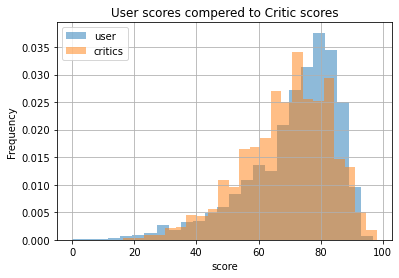

In [6]:
#null hypothesis - critic_score and user_score are equal.
#Alternative hypotheses - critic_score and user_score are not equal.
critic_score_T = test[test.critic_score.notna()].critic_score
user_score_T = test[test.user_score.notna()].user_score

alpha = 0.05  
results = st.ttest_ind(user_score_T, critic_score_T)
print('alpha:   ', alpha)
print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print('We reject the null hypothesis')
else:
    print("We can't reject the null hypothesis") 
    
ax = test['user_score'].hist(bins=25, alpha=0.5,density=True,label=['user'])
ax = test['critic_score'].hist(bins=25, alpha=0.5,density=True,label=['critics'])
plt.gca().set(title='User scores compered to Critic scores', ylabel='Frequency',xlabel='score')
ax.legend(prop={'size': 10});

critic_score and user_score are not equal so i canot use them to fill each other.

## Prepare the data

* Describe the columns where the data types have been changed and why.
* Decide how to deal with missing values: Explain why you filled in the missing values as you did or why you decided to leave them blank.
* Why do you think the values are missing? Give possible reasons.

In [7]:
games_df_ed.columns = games_df_ed.columns.str.lower()
games_df_ed.user_score.replace( "tbd" , np.NaN , inplace=True)
games_df_ed.dropna(subset=['name' ], inplace=True)
games_df_ed = games_df_ed.reset_index()
games_df_ed['tot_sales'] = games_df_ed[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

* changed column names to lowercase.
* changed "tbd" in user_score Nan (tbd didnt gave us information helpful to our research).
* droped rows without names (cant re-fill missing names)
* made new column 'tot_sales' as sum of all rigional sales.

In [8]:
games_df_ed['rating'] = games_df_ed['rating'].replace('EC', 'E')
games_df_ed['rating'] = games_df_ed['rating'].replace('K-A', 'E')
games_df_ed['rating'] = games_df_ed['rating'].replace('AO', 'M')
games_df_ed['rating'] = games_df_ed['rating'].replace('RP', np.nan)

* There are several rating inputs that diviate from the ESRB current coding system.
* I chose to change them to their compatible rank, making the rating more managble.

In [9]:
games_df_ed['user_score'] = games_df_ed['user_score'].replace('RP', np.nan)
games_df_ed['user_score'] = pd.to_numeric(games_df_ed['user_score'], errors='coerce')
games_df_ed["user_score"] = np.where(games_df_ed["user_score"] >10, np.nan,games_df_ed["user_score"])
games_df_ed.user_score = games_df_ed.user_score*10 
games_df_ed.year_of_release = pd.to_datetime(games_df_ed.year_of_release.dropna().astype('int64'), format='%Y',errors='raise')
games_df_ed.rating  = games_df_ed.rating.astype("category")
games_df_ed.genre  = games_df_ed.genre.astype("category")
games_df_ed.platform  = games_df_ed.platform.astype("category")

* I change user_score tonumerical type, and multiplied by 10 to make it the same scale as the crit_score for better handeling in the future.
* I chose to change the year_of_release to datetime.
* changed rating, genre, and platform to categoricl to save memory.

In [10]:
games_df_ed["titles"] = np.nan
for ind in range(len(games_df_ed)):
    try:
        if ':' in games_df_ed.name[ind]:
            games_df_ed['titles'][ind] = games_df_ed.name[ind].split(":")[0]
            
    except:
        print("Error")

games_df_ed['title_count'] = games_df_ed.groupby('titles')['titles'].transform('count')        

* many game names are in this format: {titles : secondery titles}.
* to increase the rating filling by names will be doing it by titles as well.

#### Filling missing data:

In [11]:
def fill_years(data):
    count = 0
    new = data.copy()
    for ind in data.index:
        try:
            if data['year_of_release'][ind] != data['year_of_release'][ind]:
                name = data['name'][ind]
                year = data[ data['name'] == name].year_of_release
                year.dropna(inplace=True)
                
                if len(year):
                    new['year_of_release'][ind] = year.value_counts().idxmax()   
                    
                elif data['title_count'][ind] > 1:
                    name = data['titles'][ind]
                    year = data[ data['titles'] == name].year_of_release
                    year.dropna(inplace=True)
                    
                    if len(year):
                        new['year_of_release'][ind] = year.value_counts().idxmax()   
        except:
            count+=1 
            
    print('Error: function failed',count ,'times.')
    return new

games_df_ed = fill_years(games_df_ed)

Error: function failed 0 times.


In the filling process I am searching for same name game as the the one with the missing value.
I save the games with simillar names in list and pick the most frequent value to replase our missing one. I do the same with the 'titles' column I prepared earlier.

In [12]:
def fill_rating(data):
    count = 0
    new = data.copy()
    for ind in data.index:
        try:
            if data['rating'][ind] != data['rating'][ind]:
                name = data['name'][ind]
                rating = data[ data['name'] == name].rating
                rating.dropna(inplace=True)
                
                if len(rating):
                    new['rating'][ind] = rating.value_counts().idxmax()   
                    
                elif data['title_count'][ind] > 1:
                    name = data['titles'][ind]
                    rating = data[ data['titles'] == name].rating
                    rating.dropna(inplace=True)
                    if len(rating):
                        new['rating'][ind] = rating.value_counts().idxmax()   
        except:
            count+=1  
            
    print('Error: function failed',count ,'times.')
    return new

games_df_ed = fill_rating(games_df_ed)

Error: function failed 0 times.


same as above.

In [13]:
def fill_rank(row):
    try:
        if row.rating == 'E':
            return 1
        if row.rating == 'E10+':
            return 2
        if row.rating == 'T':
            return 3
        if row.rating == 'M':
            return 4
        else:
            return np.nan
    except:
            print(Error)
               
games_df_ed['rating_numeric'] = games_df_ed.apply( lambda row: fill_rank(row ), axis=1)

Add new column for 'rating_numeric' that transform the rating 'str' to numeric value that can be prossesed in later analysis.

In [14]:
def fill_critic(data):
    count = 0
    new = data.copy()
    for ind in data.index:
        try:
            if data['critic_score'][ind] != data['critic_score'][ind]:
                name = data['name'][ind]
                score = data[ data['name'] == name].critic_score
                score.dropna(inplace=True)
                
                if len(score):
                    new['critic_score'][ind] = round(score.mean())  
                
                elif data['title_count'][ind] > 1:
                    name = data['titles'][ind]
                    score = data[ data['titles'] == name].critic_score
                    score.dropna(inplace=True)
                    if len(score):
                        new['critic_score'][ind] = round(score.mean())                   
        except:
            count+=1 
            
    print('Error: function failed',count ,'times.')
    return new
  
games_df_ed = fill_critic(games_df_ed)

Error: function failed 0 times.


here i pick the mean value to fill with and not the most frequent one as the score is a scale.

In [15]:
def fill_user(data):
    count = 0
    new = data.copy()
    for ind in data.index:
        try:
            if data['user_score'][ind] != data['user_score'][ind]:
                name = data['name'][ind]
                score = data[ data['name'] == name].user_score
                score.dropna(inplace=True)
                if len(score):
                    new['user_score'][ind] = round(score.mean())
                    
                elif data['title_count'][ind] > 1:
                    name = data['titles'][ind]
                    score = data[ data['titles'] == name].user_score
                    score.dropna(inplace=True)
                    if len(score):
                        new['user_score'][ind] = round(score.mean())                     
        except:
            count+=1 
            
    print('Error: function failed',count ,'times.')
    return new
  
games_df_ed = fill_user(games_df_ed)

Error: function failed 0 times.


same as above.

#### Check if the values filled didnt change our data:

alpha:    0.01
p-value:  0.10916851871512118
We can't reject the null hypothesis


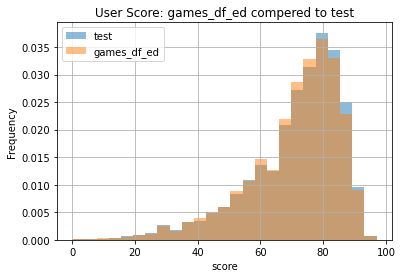

In [16]:
#null hypothesis - user_score in test and user_score in games_df_ed are equal. 
test_user = test[(test.user_score.notna())].user_score
games_df_ed_user = games_df_ed[(games_df_ed.user_score.notna())].user_score

alpha = 0.01  
results = st.ttest_ind(test_user, games_df_ed_user)
print('alpha:   ', alpha)
print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print('We reject the null hypothesis')
else:
    print("We can't reject the null hypothesis") 
    
ax = test_user.hist(bins=25, alpha=0.5,density=True,label=['test'])
ax = games_df_ed_user.hist(bins=25, alpha=0.5,density=True,label=['games_df_ed'])
plt.gca().set(title='User Score: games_df_ed compered to test', ylabel='Frequency',xlabel='score')
ax.legend(prop={'size': 10});

alpha:    0.01
p-value:  0.036509076726647154
We can't reject the null hypothesis


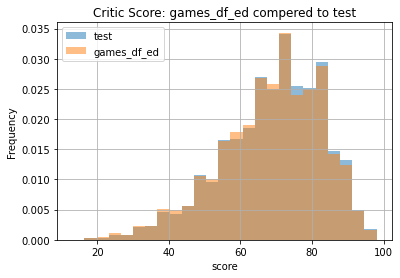

In [17]:
#null hypothesis - critic_score in test and critic_score in games_df_ed are equal. 
test_crit = test[(test.critic_score.notna())].critic_score
games_df_ed_crit = games_df_ed[(games_df_ed.critic_score.notna())].critic_score

alpha = 0.01  
results = st.ttest_ind(test_crit, games_df_ed_crit)
print('alpha:   ', alpha)
print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print('We reject the null hypothesis')
else:
    print("We can't reject the null hypothesis") 
    
ax = test_crit.hist(bins=25, alpha=0.5,density=True,label=['test'])
ax = games_df_ed_crit.hist(bins=25, alpha=0.5,density=True,label=['games_df_ed'])
plt.gca().set(title='Critic Score: games_df_ed compered to test', ylabel='Frequency',xlabel='score');
ax.legend(prop={'size': 10});

* user_score and critic_score filled in games_df_ed are equal to those in the test dataframe with 99% certainty.

In [18]:
(round(100*(test.isnull().sum()/len(test)- games_df_ed.isnull().sum()/len(games_df_ed)),2)).dropna().sort_values(ascending=False)

user_score         10.57
critic_score        9.68
rating              5.84
year_of_release     0.89
platform            0.00
other_sales         0.00
name                0.00
na_sales            0.00
jp_sales            0.00
genre               0.00
eu_sales            0.00
dtype: float64

* we can see the change in the presentage of data filled by columns.

## Analyze the data

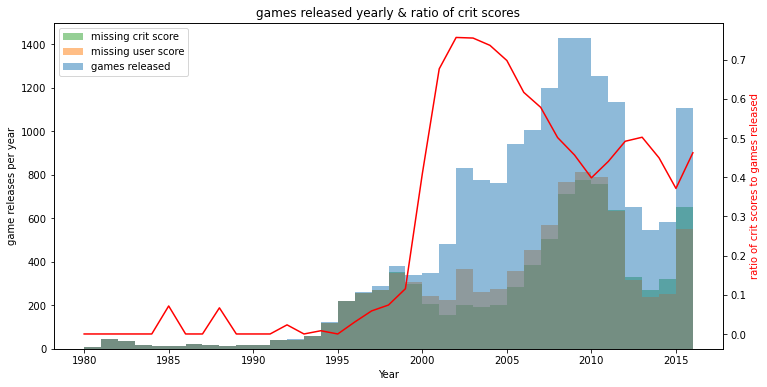

In [19]:
# plot missing_crit_user_score and gemes released by years
missing_user = test[test.user_score != test.user_score].year_of_release
missing_crit = test[test.critic_score != test.critic_score].year_of_release
game_year_release = test.year_of_release
missing_crit_user_score = [game_year_release,missing_user, missing_crit]

crit_missing_y = test[test.critic_score != test.critic_score].year_of_release.value_counts()
crit_missing_ratio = ((crit_missing_y / test.year_of_release.value_counts())-1).abs()
crit_missing_ratio = pd.DataFrame (crit_missing_ratio)

fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(missing_crit_user_score, histtype='stepfilled', alpha=0.5, bins=36, label=['games released','missing user score','missing crit score'])
ax.legend(prop={'size': 10})
ax.set_xlabel('Year')
ax.set_ylabel('game releases per year')
ax.set_title('games released yearly & ratio of crit scores')
ax.legend(loc='upper left')

ax1=ax.twinx()
ax1.plot(crit_missing_ratio,label=['ratio'],color="red")
ax1.set_ylabel("ratio of crit scores to games released",color="red")

plt.show()

we can see that tere are 3 distinct periods in games released per year:
* pre 1990, small amounts of games, the beginning of the industry.
* 1990-2000, steady growth in number of games published.
* 2000-2010, great increase in number of games published yearly.
* 2010-present, big dip in games publiushed in 2013-2015 than a recover in 2016.

the amount of non existing scores inputs can be devided into two groups:

* Pre-2000, the scoring of game was probably underdeveloped institution therefore missing scores are close to 100%.
* 2000-2005, best time in crit scores wise, 70-60% of games being being reviewed.
* 2005-present, the numbers have staibalized on 40% of games being reviewed.


* the reason for missing crit score reviews are probably because there are alot of games beeing published and to score them a critic must spend alot of hours playing and assessing the game.

* the reason for missing user score reviews are probably because it is valuntary action that the users dont get compensation for.

PS2 is the platforms with the greatest total sales of: 1255 million dollars.


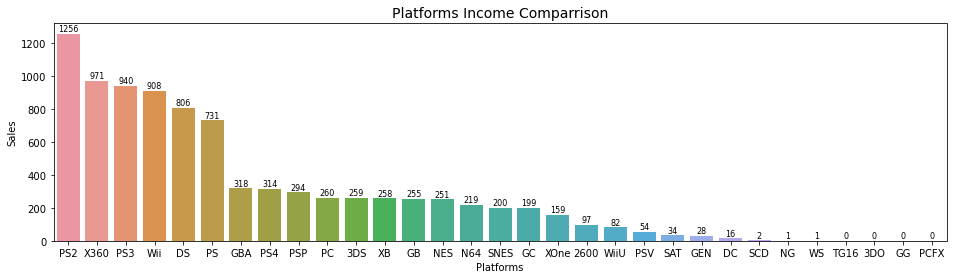

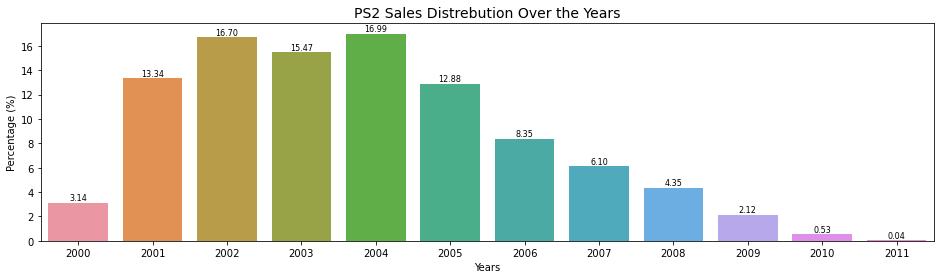

In [20]:
PS2_yearly_income = games_df_ed[games_df_ed.platform == "PS2"].groupby('year_of_release').tot_sales.sum()
PS2_yearly_income = pd.DataFrame (PS2_yearly_income)
PS2_yearly_income["sales_of_tot"] = 100*PS2_yearly_income.tot_sales / PS2_yearly_income.tot_sales.sum()
PS2_yearly_income = PS2_yearly_income.reset_index()
PS2_yearly_income["year_of_release"] = PS2_yearly_income.year_of_release.dt.year
plt_sales = games_df_ed.groupby('platform').tot_sales.sum().sort_values(ascending=False).reset_index()
print("{:} is the platforms with the greatest total sales of: {:} million dollars.".format(plt_sales.platform[0],int(plt_sales.tot_sales[0])))

plt.figure(figsize=(16, 4))
plots = sns.barplot(x="platform", y="tot_sales", data=plt_sales, order=plt_sales.platform)
 
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 5),
                   textcoords='offset points')

plt.xlabel("Platforms", size=10)
plt.ylabel("Sales", size=10)
plt.title("Platforms Income Comparrison", size=14)
plt.show()

plt.figure(figsize=(16, 4))
plots = sns.barplot(x="year_of_release", y="sales_of_tot", data=PS2_yearly_income)
 
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 5),
                   textcoords='offset points')

plt.xlabel("Years", size=10)
plt.ylabel('Percentage (%)', size=10)
plt.title("PS2 Sales Distrebution Over the Years", size=14)
plt.show()

* PS2 is the most profitable platform of all time.
* It was introdused in 2000 and lasted until 2011.
* It dominated the market between 2001-2005, afterwards it began its decline.

All active platforms ordered by sales:
  platform  tot_sales launch_year  lifespan
0     X360     971.42  2003-01-01        13
1      PS3     939.65  2005-01-01        11
2      Wii     907.51  2005-01-01        11
3      PS4     314.14  2013-01-01         3
4       PC     259.52  1985-01-01        31
5      3DS     259.00  2000-01-01        16
6     XOne     159.32  2013-01-01         3
7     WiiU      82.19  2012-01-01         4
8      PSV      54.07  2008-01-01         8 

Top 10 retired platforms ordered by sales:
  platform  tot_sales launch_year  lifespan
0      PS2    1255.77  2000-01-01        11
1       DS     806.12  1985-01-01        28
2       PS     730.86  1994-01-01         9
3      GBA     317.85  2000-01-01         7
4      PSP     294.05  2004-01-01        11
5       XB     257.74  2000-01-01         9
6       GB     255.46  1988-01-01        13
7      NES     251.05  1983-01-01        11
8      N64     218.68  1996-01-01         8
9     SNES     200.04  1990-01-01   

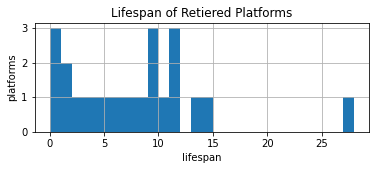

longest run for retiered platform: 28 years
platform name: DS 

longest run for active platform: 31 years
platform name: PC 

correlation between platform profitability to its lifspan: 0.6192


In [21]:
platform_df = games_df_ed.groupby('platform').tot_sales.sum()
platform_df = pd.DataFrame (platform_df)
platform_df['launch_year'] =games_df_ed.groupby('platform').year_of_release.min()
platform_df['max_year'] =games_df_ed.groupby('platform').year_of_release.max()
platform_df['lifespan'] = platform_df['max_year'].dt.year - platform_df['launch_year'].dt.year

platform_df['retired'] = False
for i in range(len(platform_df)):
    if platform_df['max_year'][i] == platform_df['max_year'].max():
        platform_df['retired'][i] = False
    else:
        platform_df['retired'][i] = True

print("All active platforms ordered by sales:")
print(platform_df[platform_df.retired == False].sort_values(by='tot_sales',ascending = False)[["tot_sales","launch_year","lifespan"]].reset_index(),"\n")
print("Top 10 retired platforms ordered by sales:")
print(platform_df[platform_df.retired == True].sort_values(by='tot_sales',ascending = False)[["tot_sales","launch_year","lifespan"]].head(10).reset_index())
  
lifspan_corr = round(platform_df[platform_df.retired == True].tot_sales.corr(platform_df[platform_df.retired == True].lifespan),4)
ax =platform_df[ platform_df.retired ].lifespan.hist(bins = 28,figsize=(6, 2))
ax.set_xlabel('lifespan')
ax.set_ylabel('platforms')
ax.set_title('Lifespan of Retiered Platforms')
plt.show()

print("longest run for retiered platform:",platform_df[ platform_df.retired ].lifespan.max(),"years")
print("platform name:",platform_df[ platform_df.retired ].lifespan.idxmax(),"\n")
print("longest run for active platform:",platform_df.lifespan.max(),"years")
print("platform name:",platform_df.lifespan.idxmax(),"\n")
print("correlation between platform profitability to its lifspan:",lifspan_corr)

There is great veriaty in platform lifspans:
* Most of platforms lifspan is about 3-12 years.
* Oldest retired platform is: DS.
* Oldest active platform is: PC.
* It seems there is a  strong correlation between platforms lifspan and its profitability.

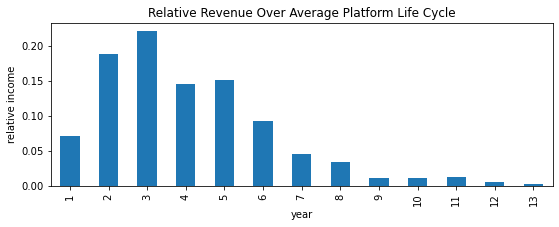

A platform on average will make 48% of its revenue by its 3th year.
A platform on average will make 92% of its revenue by its 7th year.


In [22]:
relevant_platforms = platform_df[platform_df['retired']].sort_values(by=['tot_sales'], ascending=False).query('tot_sales > 2').index
platform_sale_ratio = [np.nan]*platform_df.lifespan.max()
platform_sale_ratio = pd.DataFrame(platform_sale_ratio)

for con in list(set(relevant_platforms)):
    temp = games_df_ed[games_df_ed.platform == con].groupby('year_of_release').tot_sales.sum()
    temp = pd.DataFrame (temp)
    temp["sales_of_tot"] = temp.tot_sales / temp.tot_sales.sum()
    temp.reset_index(inplace=True)
    platform_sale_ratio[con] = temp.sales_of_tot

platform_sale_ratio.drop(labels=0,axis=1,inplace=True)
platform_sale_ratio["average"] = platform_sale_ratio.T.sum()/len(relevant_platforms)

platform_sale_ratio["year"] = list(range(1,32))
platform_sale_ratio.set_index("year",drop=True, inplace=True)

ax=platform_sale_ratio.query('year < 14')["average"].plot(kind="bar", figsize=(9, 3));
ax.set_ylabel('relative income')
ax.set_title('Relative Revenue Over Average Platform Life Cycle')
plt.show()

print("A platform on average will make {:}% of its revenue by its 3th year.".format(round(100*platform_sale_ratio.query('year < 4')["average"].sum())))
print("A platform on average will make {:}% of its revenue by its 7th year.".format(round(100*platform_sale_ratio.query('year < 8')["average"].sum())))

How long does it generally take for new platforms to appear and old ones to fade?

* I choose to check only platforms that have finished their life cycle and are retired.
* I created df with column for every retiered platforms total income.
* Turned the income to reletive income and ploted the yearly mean of all platforms to get a product income life cycle graph.

Conclusions:
1. In its 7th year it is the first time the revenue from a platform is lower then in its first year, on average a platform will make 92% of its revenue by its 7th year.

2. the maximun yearly revenue of a platform will happen in its 3rd year.

#### Determine what period you should take data for:
##### first lets look at the market as a whole divided by top developers:

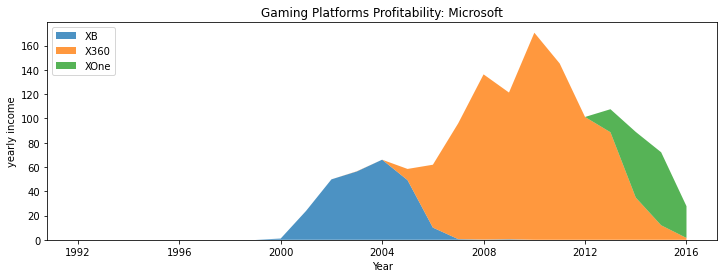

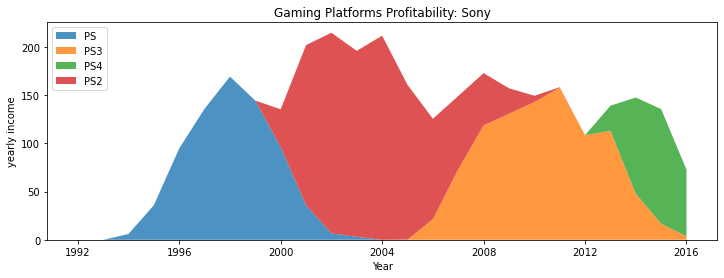

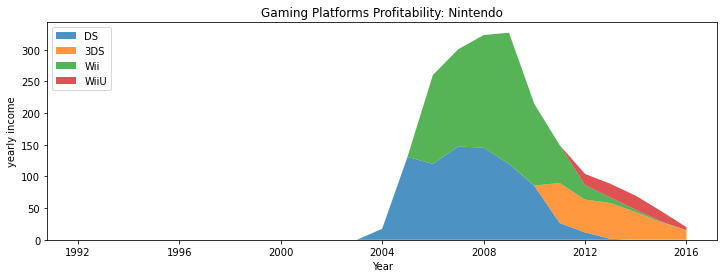

In [23]:
relevant_platforms = platform_df.sort_values(by=['tot_sales'], ascending=False).query('tot_sales > 2').index
games_df_lean2 = games_df_ed[games_df_ed.year_of_release.dt.year > 1991]
plat_income = games_df_lean2.loc[games_df_lean2['platform'].isin(relevant_platforms)]
plat_income = plat_income.groupby(["year_of_release","platform"]).tot_sales.sum().reset_index()
plat_plot = plat_income.pivot_table(index='year_of_release', columns='platform', values='tot_sales').fillna(value=0)

plat_plot_dic ={}
for col in  list(plat_plot.columns.values):
    plat_plot_dic[col] = plat_plot[col].tolist()    

res = {key: plat_plot_dic[key] for key in plat_plot_dic.keys() & {'XB', 'X360','XOne'}}
fig, ax4 = plt.subplots(figsize=(12, 4))
ax4.stackplot(plat_plot.index , res.values(),labels=res.keys(), alpha=0.8)
ax4.legend(loc='upper left')
ax4.set_title('Gaming Platforms Profitability: Microsoft')
ax4.set_xlabel('Year')
ax4.set_ylabel('yearly income')

res = {key: plat_plot_dic[key] for key in plat_plot_dic.keys() & {'PS', 'PS2','PS3','PS4'}}
fig, ax4 = plt.subplots(figsize=(12, 4))
ax4.stackplot(plat_plot.index , res.values(),labels=res.keys(), alpha=0.8)
ax4.legend(loc='upper left')
ax4.set_title('Gaming Platforms Profitability: Sony')
ax4.set_xlabel('Year')
ax4.set_ylabel('yearly income')

res = {key: plat_plot_dic[key] for key in plat_plot_dic.keys() & {'Wii', 'DS', 'WiiU','3DS'}}
fig, ax4 = plt.subplots(figsize=(12, 4))
ax4.stackplot(plat_plot.index , res.values(),labels=res.keys(), alpha=0.8)
ax4.legend(loc='upper left')
ax4.set_title('Gaming Platforms Profitability: Nintendo')
ax4.set_xlabel('Year')
ax4.set_ylabel('yearly income')
plt.show()

* I chose relevant platforms to us and grouped them by developer.
* I grouped yearly income by date and platform, them pivoted it to the proper shape.
* than I stack ploted the related platforms to represent the change between platforms generations.

Sony platforms:
* PS - retired 
* PS2 - retired
* PS3 - near the end of its life cycle
* PS4 - 3 years old, PS3 successor, has growth potential

Microsoft platforms:
* XB - retired 
* X360 - near the end of its life cycle
* XOne - 3 years old, X360 successor, has growth potential

Nintendo platforms:
* DS - retired 
* 3DS - DS successor,16 years old, no growth potential
* Wii - at the end of its life cycle
* WiiU - 4 years old, Wii successor, has growth potential

* I chose to examin games from 2014-2016 trying to catch the latest trends.

In [24]:
#Determine what period you should take data for.
games_df_lean = games_df_ed[games_df_ed.year_of_release.dt.year > 2013]
plat_lean = games_df_lean.groupby(['year_of_release','platform']).tot_sales.sum()
plat_lean = pd.DataFrame (plat_lean).reset_index()
plat_lean['yearly_precent'] = np.nan

for i in range(len(plat_lean)):
    plat_sum = plat_lean[plat_lean.year_of_release == plat_lean['year_of_release'][i]].tot_sales.sum()
    plat_lean['yearly_precent'][i] = 100*plat_lean['tot_sales'][i]/plat_sum

#Which platforms are leading in sales? 
plat_lean.groupby('platform').yearly_precent.mean().sort_values(ascending = False).head().round(2)

platform
PS4     42.60
XOne    19.62
3DS     11.73
PS3      7.81
WiiU     5.43
Name: yearly_precent, dtype: float64

* I learned that: PS4 is the dominating platform with 42% market share.

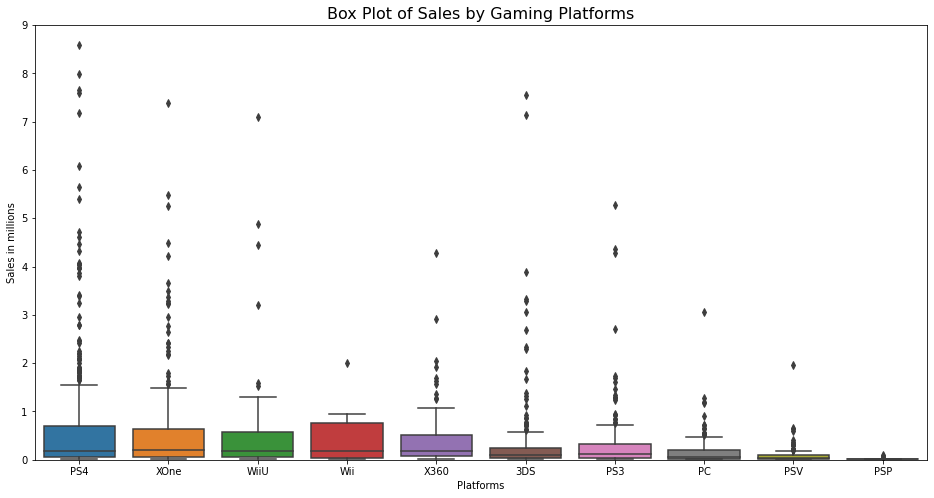

In [25]:
new_platforms =list(games_df_lean.groupby("platform").tot_sales.sum().reset_index().query("tot_sales > 0").platform)
sales_platform = games_df_lean[games_df_lean['platform'].isin(new_platforms)]
sales_platform.platform = sales_platform.platform.cat.remove_unused_categories()

plt.figure(figsize=(16,8))
order= sales_platform.groupby("platform").tot_sales.mean().sort_values(ascending=False).index
sns.boxplot(x='platform', y='tot_sales', data=sales_platform, order= order )
plt.title('Box Plot of Sales by Gaming Platforms', fontsize=16)
plt.xlabel("Platforms", size=10)
plt.ylabel('Sales in millions', size=10)
plt.ylim(0, 9)
plt.show()

* boxplot of gamesales per platform, ordered by mean.
* Wii have highest Q3 out of all the platforms, but really short tail.
* PS4 have the highest mean out of all the platforms, the reason is the large amount of profitable games that can be seen as outliers in the graph.

In [26]:
average_sales = sales_platform.groupby("platform").tot_sales.mean().sort_values(ascending=False).reset_index()
average_sales.columns = ["platform", "mean_sales"]
average_sales["percent_from_tot_sales_mean"] = 100*((average_sales.mean_sales/sales_platform.tot_sales.mean())-1)
print("Average sales on all platforms is:",round(sales_platform.tot_sales.mean(),2))
average_sales.round(2)

Average sales on all platforms is: 0.43


,platform,mean_sales,percent_from_tot_sales_mean
0,PS4,0.77,77.47
1,XOne,0.62,42.56
2,WiiU,0.59,36.34
3,Wii,0.46,6.73
4,X360,0.43,0.60
5,3DS,0.41,-5.32
6,PS3,0.31,-27.91
7,PC,0.18,-58.26
8,PSV,0.08,-82.42
9,PSP,0.03,-93.59


* PS4, XOne and WiiU are overperforming in games sales compared to the markets average.

In [27]:
print("Largest number of sales:",games_df_lean.groupby('platform').tot_sales.count().sort_values(ascending=False).idxmax())

Largest number of sales: PS4


* I chose to compare user and professional reviews affect on sales for the platform with sale data: PS4

#### I chose to compare user and professional reviews affect on sales for 'PS4' platform.

User and professional reviews affect on sales for PS4:


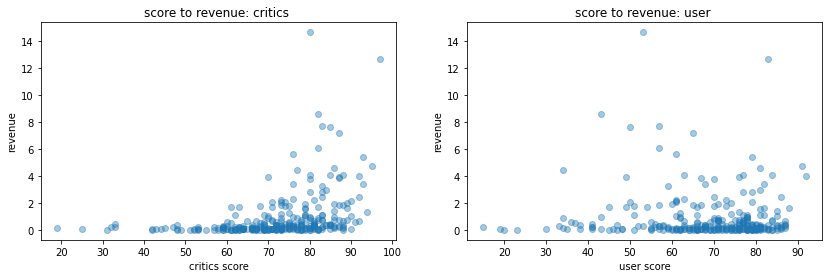

           tot_sales  critic_score  user_score
tot_sales        1.0      0.353668   -0.053648 

---------------------------------------------------------------------------------------------

User and professional reviews affect on sales for XOne:


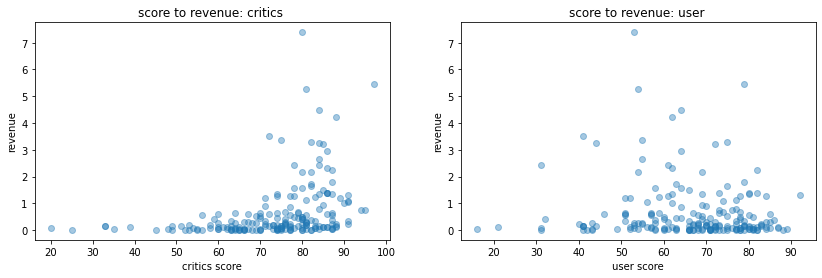

           tot_sales  critic_score  user_score
tot_sales        1.0      0.347311   -0.101439 

---------------------------------------------------------------------------------------------

User and professional reviews affect on sales for WiiU:


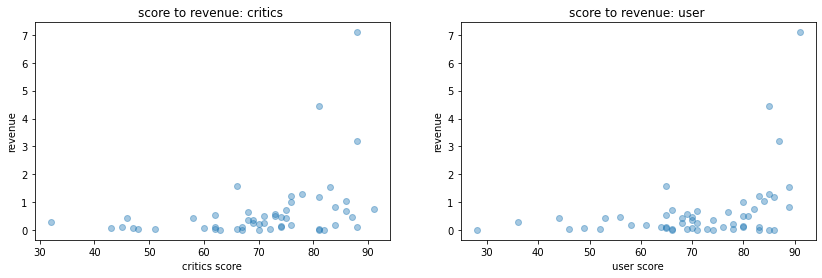

           tot_sales  critic_score  user_score
tot_sales        1.0      0.372662    0.386228 



In [28]:
nintendo_ds = games_df_lean[games_df_lean.platform == "PS4"][[ "tot_sales", "critic_score", "user_score"]]
ds_corr = nintendo_ds.corr()
ds_ratio = round(100*(ds_corr.critic_score[0]/ds_corr.user_score[0]-1))

print("User and professional reviews affect on sales for PS4:")
fig, ax = plt.subplots(1,2,figsize=(14, 4))
ax[0].scatter(nintendo_ds.critic_score, nintendo_ds.tot_sales,alpha=0.4 )
ax[0].set_xlabel('critics score')
ax[0].set_ylabel('revenue')
ax[0].set_title('score to revenue: critics ')

ax[1].scatter(nintendo_ds.user_score, nintendo_ds.tot_sales,alpha=0.4)
ax[1].set_xlabel('user score')
ax[1].set_ylabel('revenue')
ax[1].set_title('score to revenue: user ')
plt.show()

print(ds_corr.head(1),"\n")
print("---------------------------------------------------------------------------------------------\n")

#ds_game_list = games_df_lean[games_df_lean.platform == "PS4"].name
#ds_games_df = games_df_lean.loc[games_df_lean.name.isin(ds_game_list)]
nintendo_ds = games_df_lean[games_df_lean.platform == "XOne"][[ "tot_sales", "critic_score", "user_score"]]
ds_corr = nintendo_ds.corr()
ds_ratio = round(100*(ds_corr.critic_score[0]/ds_corr.user_score[0]-1))

print("User and professional reviews affect on sales for XOne:")
fig, ax = plt.subplots(1,2,figsize=(14, 4))
ax[0].scatter(nintendo_ds.critic_score, nintendo_ds.tot_sales,alpha=0.4 )
ax[0].set_xlabel('critics score')
ax[0].set_ylabel('revenue')
ax[0].set_title('score to revenue: critics ')

ax[1].scatter(nintendo_ds.user_score, nintendo_ds.tot_sales,alpha=0.4)
ax[1].set_xlabel('user score')
ax[1].set_ylabel('revenue')
ax[1].set_title('score to revenue: user ')
plt.show()

print(ds_corr.head(1),"\n")
print("---------------------------------------------------------------------------------------------\n")

#ds_game_list = games_df_lean[games_df_lean.platform == "PS4"].name
#ds_games_df = games_df_lean.loc[games_df_lean.name.isin(ds_game_list)]
nintendo_ds = games_df_lean[games_df_lean.platform == "WiiU"][[ "tot_sales", "critic_score", "user_score"]]
ds_corr = nintendo_ds.corr()
ds_ratio = round(100*(ds_corr.critic_score[0]/ds_corr.user_score[0]-1))

print("User and professional reviews affect on sales for WiiU:")
fig, ax = plt.subplots(1,2,figsize=(14, 4))
ax[0].scatter(nintendo_ds.critic_score, nintendo_ds.tot_sales,alpha=0.4 )
ax[0].set_xlabel('critics score')
ax[0].set_ylabel('revenue')
ax[0].set_title('score to revenue: critics ')

ax[1].scatter(nintendo_ds.user_score, nintendo_ds.tot_sales,alpha=0.4)
ax[1].set_xlabel('user score')
ax[1].set_ylabel('revenue')
ax[1].set_title('score to revenue: user ')
plt.show()

print(ds_corr.head(1),"\n")

PS4: 
* User score has no correlation to sales, the conclusion is that users score cannot predict games success financially.
* Critics score has positive corelation with games success, we can asume that they are doing a good job assessing games quality.


XOne: 
* User score has negetive correlation to sales, the conclusion is that users score cannot predict games success financially.
* Critics score has positive corelation with games success, we can asume that they are doing a good job assessing games quality.

WiiU: 
* Critics score and user scores has positive corelation with games success, we can asume that they are doing a good job assessing games quality.

#### compare the sales of the same games on other platforms:

In [29]:
ds_game_list = games_df_lean[games_df_lean.platform == "PS4"].name
ds_games_cross_plat = games_df_lean.pivot_table(index='name', columns='platform', values='tot_sales').fillna(value=0)
ds_games_cross_plat = ds_games_cross_plat.loc[ds_games_cross_plat.index.isin(ds_game_list)]
ds_games_share_ratio = round((100*ds_games_cross_plat.sum()/ds_games_cross_plat.sum().sum()),2).sort_values(ascending = False)

print("PS4 games revenue share by platform is:")
print(ds_games_share_ratio.head(6))

PS4 games revenue share by platform is:
platform
PS4     52.80
XOne    21.34
PS3     10.28
X360     7.34
PC       3.35
PSV      1.84
dtype: float64


* Games that are present on the 'PS4' platform are mostly being played on 'PS4' with more than 52% of all game sales share.

In [30]:
genre_df = games_df_lean.groupby("genre").index.count()
genre_df= pd.DataFrame (genre_df).reset_index()
genre_df.columns = ["genre", "game_count"]
genre_df["game_ratio"] = 100*genre_df.game_count / genre_df.game_count.sum()

genre_df2 =games_df_lean.groupby("genre").tot_sales.sum().reset_index()
genre_df2.columns = ["genre", "tot_sales"]
genre_df2["tot_sales_ratio"] = 100*genre_df2.tot_sales / genre_df2.tot_sales.sum()

genre_df = pd.merge(left = genre_df , right = genre_df2, how='outer',on='genre')
genre_df = genre_df.set_index("genre")
genre_df["profitability_ratio"] = genre_df.tot_sales_ratio/genre_df.game_ratio

genre_df.reset_index().sort_values("profitability_ratio",ascending=False).head()

,genre,game_count,game_ratio,tot_sales,tot_sales_ratio,profitability_ratio
8,Shooter,128,7.573964,170.94,23.422856,3.092549
10,Sports,161,9.526627,109.48,15.001370,1.574678
4,Platform,38,2.248521,18.09,2.478761,1.102396
2,Fighting,60,3.550296,28.22,3.866813,1.089152
7,Role-Playing,221,13.076923,101.44,13.899699,1.062918


* I grouped games by genere, counted games and total sales and calculated their share as well as the profitabillity ratio.

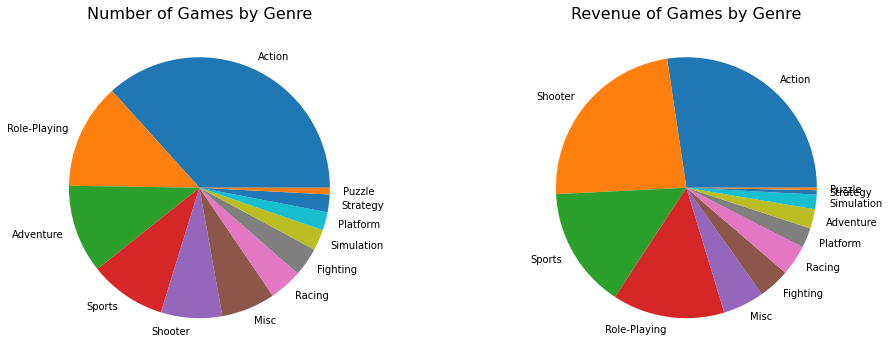

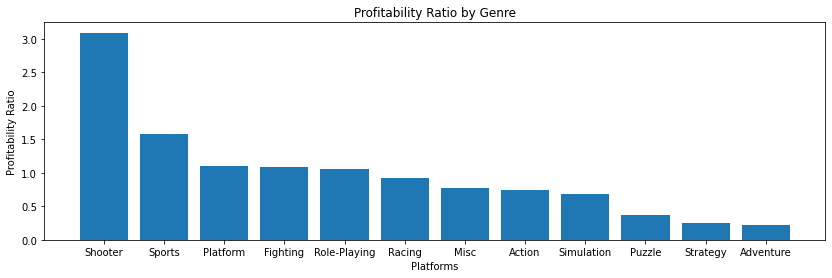

In [31]:
fig, ax = plt.subplots(1,2,figsize=(16, 6))
ax[0].pie( genre_df.game_count.sort_values(ascending=False), labels=genre_df.game_count.sort_values(ascending=False).index )
ax[0].set_title('Number of Games by Genre',fontsize=16)
ax[1].pie(genre_df.tot_sales.sort_values(ascending=False),labels=genre_df.tot_sales.sort_values(ascending=False).index )
ax[1].set_title('Revenue of Games by Genre', fontsize=16)

fig2, ax1 = plt.subplots(1,1,figsize=(14, 4))
ax1.bar( genre_df.profitability_ratio.sort_values(ascending=False).index, genre_df.profitability_ratio.sort_values(ascending=False))
plt.gca().set(title='Profitability Ratio by Genre', ylabel='Profitability Ratio',xlabel='Platforms');
plt.show()

* Most profitable genres are those with the greatest revenue and the smallest number of games.
* Shooter is 3 times more profitable than other genres.
* Sports  is 1.5 times more profitable than other genres.
* Action Sports and Shooters genres are with the highest sales.
* Strategy Puzzle and Simulation genres are with the lowest sales.
* My assumption is that Strategy Puzzle and Simulation are slower paced games and with steeper learning curve compered to Action Sports and Shooters and therfore are more of a niche genres.

## Create a user profile for each region
For each region (NA, EU, JP), determine:
* The top five platforms. Describe variations in their market shares from region to region.
* The top five genres. Explain the difference.
* Do ESRB ratings affect sales in individual regions?

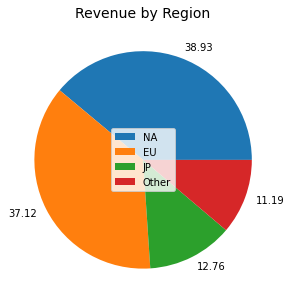

In [32]:
regional_share = games_df_lean[['na_sales','eu_sales','jp_sales','other_sales']].sum().reset_index()
regional_share = pd.DataFrame (regional_share)
regional_share.columns = ["region","sales"]
regional_share.region = ["NA", "EU", "JP", "Other"]
regional_share["share"] = 100*regional_share.sales / regional_share.sales.sum()
regional_share

fig, ax = plt.subplots(1,1,figsize=(5, 5))
ax.pie(regional_share.sales , labels=round(regional_share.share,2) )
ax.set_title('Revenue by Region', fontsize=14)
ax.legend(regional_share.region,prop={'size': 10}, loc = 'center')
plt.show()

* NA and EU are roughly same size market share.
* NA and EU together represent 76% of the gaming market.
* JP and other also are with similar market share.

In [33]:
NA_top_plat = games_df_lean.groupby("platform").na_sales.sum().sort_values(ascending=False).reset_index()
NA_top_plat.na_sales = round(100*NA_top_plat.na_sales/NA_top_plat.na_sales.sum(),2)
NA_top_gnere = games_df_lean.groupby("genre").na_sales.sum().sort_values(ascending=False).reset_index()
NA_top_gnere.na_sales = round(100*NA_top_gnere.na_sales/NA_top_gnere.na_sales.sum(),2)
header = pd.MultiIndex.from_product([['NA'], ['platform','p_share','genre','g_share']], names=['regions','ranking'])
NA_top = pd.merge(left = NA_top_plat , right = NA_top_gnere, left_index=True, right_index=True,how='outer')
NA_top.columns=header

EU_top_plat = games_df_lean.groupby("platform").eu_sales.sum().sort_values(ascending=False).reset_index()
EU_top_plat.eu_sales = round(100*EU_top_plat.eu_sales/EU_top_plat.eu_sales.sum(),2)
EU_top_gnere = games_df_lean.groupby("genre").eu_sales.sum().sort_values(ascending=False).reset_index()
EU_top_gnere.eu_sales = round(100*EU_top_plat.eu_sales/EU_top_plat.eu_sales.sum(),2)
header = pd.MultiIndex.from_product([['EU'], ['platform','p_share','genre','g_share']], names=['regions','ranking'])
EU_top = pd.merge(left = EU_top_plat , right = EU_top_gnere, left_index=True, right_index=True,how='outer')
EU_top.columns=header

JP_top_plat = games_df_lean.groupby("platform").jp_sales.sum().sort_values(ascending=False).reset_index()
JP_top_plat.jp_sales = round(100*JP_top_plat.jp_sales/JP_top_plat.jp_sales.sum(),2)
JP_top_gnere = games_df_lean.groupby("genre").jp_sales.sum().sort_values(ascending=False).reset_index()
JP_top_gnere.jp_sales = round(100*JP_top_plat.jp_sales/JP_top_plat.jp_sales.sum(),2)
header = pd.MultiIndex.from_product([['JP'], ['platform','p_share','genre','g_share']], names=['regions','ranking'])
JP_top = pd.merge(left = JP_top_plat , right = JP_top_gnere, left_index=True, right_index=True,how='outer')
JP_top.columns=header

region_compare = pd.merge(left = NA_top , right = EU_top, left_index=True, right_index=True,how='outer')
region_compare = pd.merge(left = region_compare , right = JP_top, left_index=True, right_index=True,how='outer')
region_compare = region_compare.set_index([list(range(1,len(region_compare)+1))])
region_compare.head()

regions       NA                                     EU                        \
ranking platform p_share         genre g_share platform p_share         genre   
1            PS4   34.71       Shooter   27.81      PS4   48.00        Action   
2           XOne   28.60        Action   25.55     XOne   17.07       Shooter   
3           X360    9.96        Sports   16.24      PS3    9.43        Sports   
4            3DS    7.97  Role-Playing   11.78       PC    6.72  Role-Playing   
5            PS3    7.76          Misc    5.30      3DS    5.95        Racing   

regions               JP                                
ranking g_share platform p_share         genre g_share  
1         48.00      3DS   47.52  Role-Playing   47.52  
2         17.07      PS4   16.13        Action   16.13  
3          9.43      PSV   15.62      Fighting   15.62  
4          6.72      PS3   12.05          Misc   12.05  
5          5.95     WiiU    7.85       Shooter    7.85

When comparing regions we can see that NA and EU are very similar while JP is very much distinct in nature.

Platforms:
* PS4 and XOne are 1st and 2nd most popular platforms in NA and EU.
* X360 is present only in NA top 5 platforms.
* PC is present only in EU top 5 platforms.
* 3DS is most popular platforms in JP, and it is also portable.
* 2 out of top 5 platforms in JP are portable.
* XOne is not present in JP top 5 platforms.
* all top 5 platforms in JP region belong to japanese company, here is an article explaining the reasons why: https://www.japan-zone.com/features/103_why_xbox_failed_in_japan.shtml

Genres:
* NA and EU have the same top 4 genres and in a different order.
* 'Role-Playing' is 1st genre in JP while only 4th in NA and EU.
* 'Fighting' is is only present in JP top 5.

Regions:
* NA has more balanced distribution of platforms and genres.
* EU has strong preferance to PS4 and Action games.
* JP has strong preferance to 3DS and Role-Playing games.

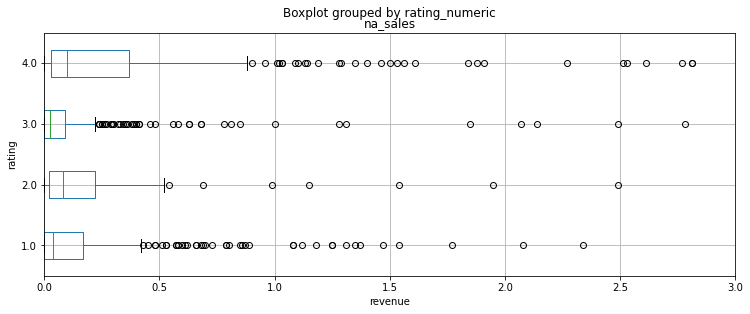

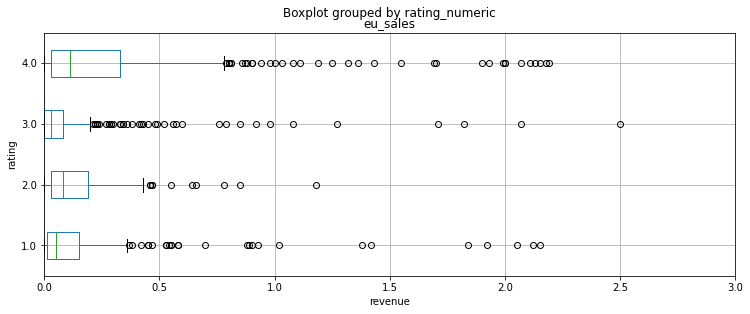

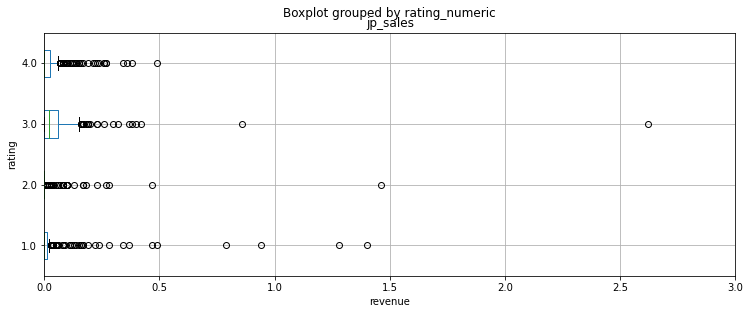

NA sales correlation to rating: 0.0943
EU sales correlation to rating: 0.0615
JP sales correlation to rating: -0.0119


In [34]:
ax = games_df_lean.boxplot(column=['na_sales'],by='rating_numeric',vert=False,figsize=(12, 4.5))
ax.set_xlim(0, 3)
ax.set_ylabel('rating')
ax.set_xlabel('revenue')
plt.show()

ax = games_df_lean.boxplot(column=['eu_sales'],by='rating_numeric',vert=False,figsize=(12, 4.5))
ax.set_xlim(0, 3)
ax.set_ylabel('rating')
ax.set_xlabel('revenue')
plt.show()

ax = games_df_lean.boxplot(column=['jp_sales'],by='rating_numeric',vert=False,figsize=(12, 4.5))
ax.set_xlim(0, 3)
ax.set_ylabel('rating')
ax.set_xlabel('revenue')
plt.show()

na_corr = round(games_df_lean.na_sales.corr(games_df_lean.rating_numeric),4)
eu_corr = round(games_df_lean.eu_sales.corr(games_df_lean.rating_numeric),4)
jp_corr = round(games_df_lean.jp_sales.corr(games_df_lean.rating_numeric),4)

print("NA sales correlation to rating:",na_corr)
print("EU sales correlation to rating:",eu_corr)
print("JP sales correlation to rating:",jp_corr)

* The correlation of ESRB rating to a games revenue is close to zero in all rigions.
* The correlation is positive in NA and EU which means that mature content in video games have little but positive impact on sales.
* Mature ESRB rating (M,4) in NA and EU have the highest sales median and Q3.

## Test the following hypotheses:
* Average user ratings of the Xbox One and PC platforms are the same.
* Average user ratings for the Action and Sports genres are different.

Set the alpha threshold value yourself:
* How you formulated the null and alternative hypotheses
* What significance level you chose to test the hypotheses, and why

Null Hypothesis:
There are no statistical significant differences between the average user ratings by the platform Xbox One and PC platform.

Alternative Hypothesis:
There is statistical significant differences between the average user ratings by the platform Xbox One and PC platform.

Critical level of statistical significance that we will use: 0.01

Test the Hypotheses:
XOne user score mean: 66.4
PC user score mean:   63.1
alpha:                0.01
p-value:              0.06147603132323841


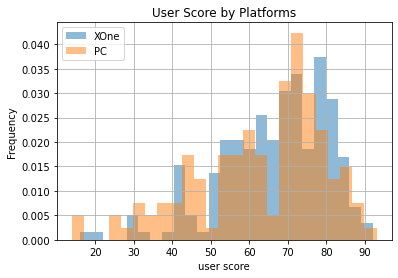

We can't reject the null hypothesis


In [35]:
print("Null Hypothesis:\nThere are no statistical significant differences between the average user ratings by the platform Xbox One and PC platform.")
print("\nAlternative Hypothesis:\nThere is statistical significant differences between the average user ratings by the platform Xbox One and PC platform.")
print("\nCritical level of statistical significance that we will use: 0.01")

XOne = games_df_lean[(games_df_lean.platform == "XOne" )& (games_df_lean.user_score.notna())].user_score
PC = games_df_lean[(games_df_lean.platform == "PC" )& (games_df_lean.user_score.notna())].user_score
alpha = 0.01  
results = st.ttest_ind(XOne, PC)

print("\nTest the Hypotheses:")
print("XOne user score mean:",round(XOne.mean(),1))
print("PC user score mean:  ",round(PC.mean(),1))
print('alpha:               ', alpha)
print('p-value:             ', results.pvalue)

ax = XOne.hist(bins=25, alpha=0.5,density=True,label=['XOne'])
ax = PC.hist(bins=25, alpha=0.5,density=True,label=['PC'])
plt.gca().set(title='User Score by Platforms', ylabel='Frequency',xlabel='user score');
ax.legend(prop={'size': 10})
plt.show()

if (results.pvalue < alpha):
    print('We reject the null hypothesis')
else:
    print("We can't reject the null hypothesis") 

* I chose alpha equle 0.01 because of the scale of the dataset, and to get high statistical significance. 
* There are no statistical significant differences between the average user ratings by the platform Xbox One and PC platform.

Null Hypothesis:
There are no statistical significant differences between the average user ratings by the 'Action' genre and 'Sports' genre.

Alternative Hypothesis:
There is statistical significant differences between the average user ratings by the 'Action' genre and 'Sports' genre.

Critical level of statistical significance that we will use: 0.01

Test the Hypotheses:
Action user score mean: 68.2
Sports user score mean: 52.0
alpha:                  0.01
p-value:                1.7433028930216702e-25


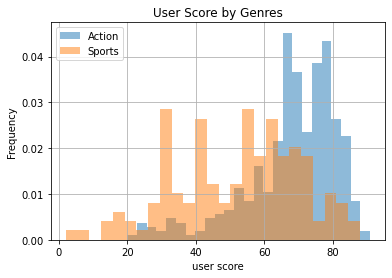

We reject the null hypothesis


In [36]:
print("Null Hypothesis:\nThere are no statistical significant differences between the average user ratings by the 'Action' genre and 'Sports' genre.")
print("\nAlternative Hypothesis:\nThere is statistical significant differences between the average user ratings by the 'Action' genre and 'Sports' genre.")
print("\nCritical level of statistical significance that we will use: 0.01")

Action = games_df_lean[(games_df_lean.genre == "Action" )& (games_df_lean.user_score.notna())].user_score
Sports = games_df_lean[(games_df_lean.genre == "Sports" )& (games_df_lean.user_score.notna())].user_score
alpha = 0.01  
results = st.ttest_ind(Action, Sports)

print("\nTest the Hypotheses:")
print("Action user score mean:",round(Action.mean(),1))
print("Sports user score mean:",round(Sports.mean(),1))
print('alpha:                 ', alpha)
print('p-value:               ', results.pvalue)

ax = Action.hist(bins=25, alpha=0.5,density=True,label=['Action'])
ax = Sports.hist(bins=25, alpha=0.5,density=True,label=['Sports'])
plt.gca().set(title='User Score by Genres', ylabel='Frequency',xlabel='user score');
ax.legend(prop={'size': 10})
plt.show()

if (results.pvalue < alpha):
    print('We reject the null hypothesis')
else:
    print("We can't reject the null hypothesis") 

* There is statistical significant differences between the average user ratings by the 'Action' genre and 'Sports' genre.
* 'Action' genre players on average giving their games 16 more user score points compared to 'Sports' genre players.

## general conclusions

###### Findings:
* Yearly number of games published has been seeing great growth in the eary 2000's up until 2010.
* There was decline in number of games published in resent years.
* PS2 is the most profitable platform of all time.
* PC is the oldest active platform with 31 years on the market.
* On average a platform will make 92% of its revenue by its 7th year on the market.
* In the past 3 years PS4 is the dominating platform with 42% market share.
* PS4 have the highest sales mean out of all the platforms.
* PS4, XOne and WiiU are overperforming in games sales compared to the markets average.
* User score has low correlation to sales, while critics score has positive corelation with games sales.
* Shooter is 3 times more profitable than other genres.
* Shooters Platform and Sports are the most profitable genres. 
* Action, Sports and Shooters genres are with the highest sales.
* NA and EU are roughly same size market share, and together they represent 76% of the gaming market.
* PS4 and XOne are 1st and 2nd most popular platforms in NA and EU.
* NA and EU regions sharing similar characteristics.
* 3DS is most popular platforms in JP.
* all top 5 platforms in JP region belong to japanese company.
* EU has strong preferance to PS4 and Action games.
* JP has strong preferance to 3DS and Role-Playing games.
* The correlation of ESRB rating to a games revenue is close to zero in all rigions.
* Mature ESRB rating in NA and EU have the highest sales median and Q3.
* There are no statistical significant differences between the average user ratings by the platform Xbox One and PC platform.
* There is statistical significant differences between the average user ratings by the 'Action' genre and 'Sports' genre.

###### Recomendations: 

For a game to succeed there are several factors to consider:
1. Platform:
* Need a presence on at least one of the "new-gen" platforms: 'PS4', 'XOne', or 'WiiU'.
* Presence on 'PC' is always good as it is not "aging" like other platforms.

2. Region:
* NA represent ~39% of the gaming market.
* NA and EU together represent ~76% of the market.
* Game must be find success in NA and EU.
* Because NA and EU have similar preferances.
* JP is hard rigion dominated by its local companies, platforms and genres.

3. Genre:
* Most popular genres are: 'Action', 'Sports' and 'Shooters'.
* Most profitable genres are: 'Shooter' and 'Sports'.
* Genres to avoid (low profitability): 'Adventure', 'Strategy' and 'Puzzle'.